##  Torso Bounding Box Prediction Project

 This project aims to build a model that can identify the torso in images and draw a bounding box around it to localize the object. The dataset used for this project is the Frames Labeled In Cinema (FLIC) dataset.

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


## Data Preparation

First, we load the bounding box annotations from the CSV file and preprocess the images by resizing them to a consistent size.

In [2]:
# Load bounding box annotations
data = pd.read_csv("bbox.csv")
filenames = data["filename"].tolist()
bounding_boxes = data["bounding_box"].apply(lambda x: np.fromstring(x[1:-1], sep=' ')).tolist()
labels = [0] * len(bounding_boxes)  # Assign a constant label (0) to all bounding boxes

In [3]:
# Load and preprocess images with resizing
final_image_height = 128
final_image_width = 128

# Original Image Size (Manually Checked)
image_height = 420
image_width = 720

In [4]:
images = []
for filename in filenames:
    image_path = os.path.join("images", filename)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (final_image_width, final_image_height))
    images.append(image)

images = np.array(images) / 255.0

## Data Augmentation
We apply data augmentation to increase the diversity of the training dataset and improve model generalization.

In [5]:
def check_128(num):
    # To Avoid Some Edge Cases
    if num > 128:
        num = 128
    return num

def parse_bounding_box(bbox_str, image_width, image_height):
    bbox_values = bbox_str.replace('[', '').replace(']', '').split()
    x_min, y_min, x_max, y_max = [float(value) for value in bbox_values]
    x_min, y_min = x_min * 128 / image_width, y_min * 128 / image_height
    x_max, y_max = x_max * 128 / image_width, y_max * 128 / image_height
    normalized_bbox = [check_128(x_min), check_128(y_min), check_128(x_max), check_128(y_max)]
    return normalized_bbox

In [6]:
# Load data and parse bounding box coordinates
resized_boundingbox = []
with open('bbox.csv', 'r') as f:
    next(f)  # Skip the header line
    for line in f.readlines():
        parts = line.strip().split(',')
        filename = parts[1]
        bounding_box = parse_bounding_box(parts[2], image_width, image_height)
        resized_boundingbox.append(bounding_box)

In [7]:
resized_boundingbox[8] # Checking Resize BBOX

[65.83988088888889, 73.12271238095238, 86.86860977777778, 127.19659580952381]

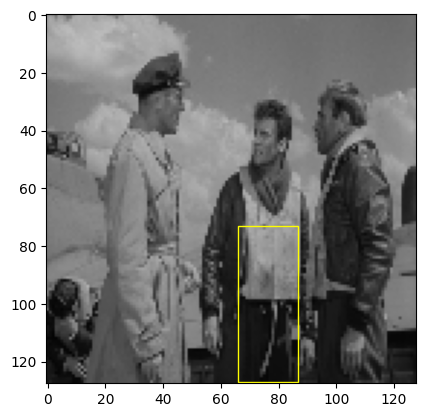

In [8]:
# How to plot
imn = 8 # Image Number

fig, ax = plt.subplots()
ax.imshow(images[imn])
ax.add_patch(Rectangle((resized_boundingbox[imn][0], resized_boundingbox[imn][1]), 
                       resized_boundingbox[imn][2]-resized_boundingbox[imn][0], 
                       resized_boundingbox[imn][3]-resized_boundingbox[imn][1],
                       edgecolor = 'yellow',
             fill=False))
plt.show()

In [9]:
# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(images, resized_boundingbox, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [10]:
# Define Albumentations bounding box augmentation
bbox_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
], bbox_params=A.BboxParams(format='pascal_voc'))

In [11]:
# Apply augmentations using Albumentations
augmented_images = []
augmented_bboxes = []

for img, bbox in zip(X_train, y_train):
    x_min, y_min, x_max, y_max = bbox  # Unpack the coordinates

    # Apply augmentations
    augmented = bbox_transform(image=img, bboxes=[[x_min, y_min, x_max, y_max, 0]])
    # Also Append the Original Image
    augmented_images.append(img)
    augmented_images.append(augmented['image'])
    # Also Append the Original BBox
    augmented_bboxes.append((x_min, y_min, x_max, y_max))
    augmented_bboxes.append(augmented['bboxes'][0][:-1])
    

X_train_augmented = np.stack(augmented_images)  # Stack augmented images into an array
y_train_augmented = np.array(augmented_bboxes)   # Convert augmented bounding boxes to an array

In [12]:
X_train_augmented.shape, y_train_augmented.shape

((7004, 128, 128, 3), (7004, 4))

In [13]:
batch_size=16

## Dataset and Model Preparation
#
 We prepare the dataset and build a simple Convolutional Neural Network (CNN) model.


In [14]:
final_x_train = tf.data.Dataset.from_tensor_slices(X_train_augmented)
final_y_train = tf.data.Dataset.from_tensor_slices(y_train_augmented)

train_ds = tf.data.Dataset.zip((final_x_train, final_y_train))
del final_x_train, final_y_train, X_train_augmented, y_train_augmented

final_x_val = tf.data.Dataset.from_tensor_slices(X_val)
final_y_val = tf.data.Dataset.from_tensor_slices(y_val)

val_ds = train_ds = tf.data.Dataset.zip((final_x_val, final_y_val))

final_x_test = tf.data.Dataset.from_tensor_slices(X_test)
final_y_test = tf.data.Dataset.from_tensor_slices(y_test)

test_ds = train_ds = tf.data.Dataset.zip((final_x_test, final_y_test))

In [15]:
# Batching and Prefetching for memory managment
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16

train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)  # Output layer with 4 units
])

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)               7

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Define callbacks
checkpoint = ModelCheckpoint(filepath='best_model.h5',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               mode='min',
                               verbose=1)

In [20]:
# Train the model with callbacks
history = model.fit(train_ds, batch_size=16,
                    epochs=100, validation_data=val_ds,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/100
47/47 [==============================] - ETA: 0s - loss: 2559.7329
Epoch 1: val_loss improved from inf to 814.34027, saving model to best_model.h5
47/47 [==============================] - 18s 349ms/step - loss: 2559.7329 - val_loss: 814.3403
Epoch 2/100
47/47 [==============================] - ETA: 0s - loss: 653.3831
Epoch 2: val_loss improved from 814.34027 to 643.75140, saving model to best_model.h5
47/47 [==============================] - 14s 301ms/step - loss: 653.3831 - val_loss: 643.7514
Epoch 3/100
47/47 [==============================] - ETA: 0s - loss: 564.1390
Epoch 3: val_loss improved from 643.75140 to 555.31409, saving model to best_model.h5
47/47 [==============================] - 14s 296ms/step - loss: 564.1390 - val_loss: 555.3141
Epoch 4/100
47/47 [==============================] - ETA: 0s - loss: 492.4691
Epoch 4: val_loss improved from 555.31409 to 492.36386, saving model to best_model.h5
47/47 [==============================] - 14s 300ms/step - loss: 49

## Model Evaluation and Visualization

In [21]:
# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

In [35]:
# Evaluate the model on the test set
test_loss = best_model.evaluate(test_ds, verbose=0)

In [38]:
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 219.4736


In [25]:
# Visualize the model's predictions on a sample image
sample_image = X_test[0]
sample_bbox = y_test[0]

In [26]:
predicted_bbox = best_model.predict(np.array([sample_image]))[0]

1/1 [==============================] - 1s 777ms/step


In [27]:
# Function to draw bounding boxes
def draw_bounding_box(image, bbox, color=(0, 1, 0), thickness=2):
    x_min, y_min, x_max, y_max = bbox
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)

In [28]:
# Create a copy of the sample image for visualization
sample_image_copy = np.copy(sample_image)

In [29]:
# Draw the ground truth bounding box in green
draw_bounding_box(sample_image_copy, sample_bbox, color=(0, 1, 0), thickness=2)

In [30]:
# Draw the predicted bounding box in red
draw_bounding_box(sample_image_copy, predicted_bbox, color=(1, 0, 0), thickness=2)

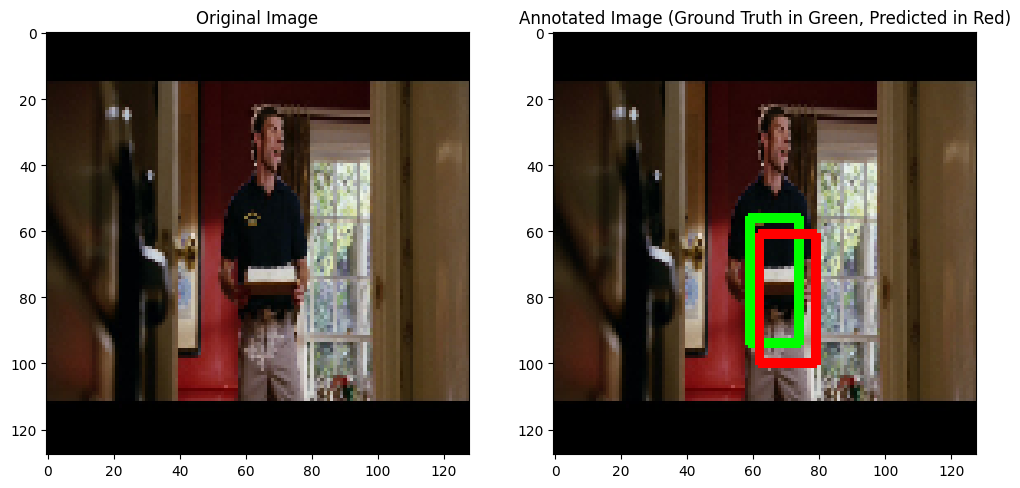

In [33]:
# Plot the original and annotated images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(sample_image)
axes[0].set_title("Original Image")

axes[1].imshow(sample_image_copy)
axes[1].set_title("Annotated Image (Ground Truth in Green, Predicted in Red)")
# Display the images
plt.show()

## Conclusion


In this project, we successfully built a model that can identify the torso in images and draw bounding boxes around it to localize the object. We achieved this through the following steps:

- Data preparation: We loaded the FLIC dataset, extracted bounding box annotations, and resized images to a consistent size.
- Data augmentation: We applied data augmentation techniques using the Albumentations library to increase the diversity of the training dataset.
- Model preparation: We built a convolutional neural network (CNN) model for bounding box prediction.
- Model training: We trained the model using the training dataset and applied early stopping to prevent overfitting.
- Model evaluation: We evaluated the model on the test dataset and visualized its predictions.

The project demonstrates how to handle image data, preprocess it, and build a model for object localization. Further improvements could involve using more advanced models, fine-tuning hyperparameters, and exploring other object detection techniques.

Overall, this project provides a solid foundation for building models that can identify and localize objects in images, which is a fundamental task in computer vision applications.